In [1]:
import os
import shutil
import tarfile
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
# Get the current working directory
current_folder = os.getcwd()
 
dataset = tf.keras.utils.get_file(
    fname ="aclImdb.tar.gz", 
    origin ="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    cache_dir=  current_folder,
    extract = True)

84125825/84125825 [==============================] - 2s 0us/step


In [3]:
dataset_path = os.path.dirname(dataset)
# Check the dataset
os.listdir(dataset_path)

['aclImdb', 'aclImdb.tar.gz']

In [4]:
# Dataset directory
dataset_dir = os.path.join(dataset_path, 'aclImdb')
 
# Check the Dataset directory
os.listdir(dataset_dir)

['README', 'test', 'train', 'imdb.vocab', 'imdbEr.txt']

In [5]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['urls_pos.txt',
 'urls_unsup.txt',
 'unsupBow.feat',
 'pos',
 'unsup',
 'neg',
 'urls_neg.txt',
 'labeledBow.feat']

In [6]:
for file in os.listdir(train_dir):
    file_path = os.path.join(train_dir, file)
    # Check if it's a file (not a directory)
    if os.path.isfile(file_path): 
        with open(file_path, 'r', encoding='utf-8') as f:
            first_value = f.readline().strip()
            print(f"{file}: {first_value}")
    else:
        print(f"{file}: {file_path}")

urls_pos.txt: http://www.imdb.com/title/tt0453418/usercomments
urls_unsup.txt: http://www.imdb.com/title/tt0018515/usercomments
unsupBow.feat: 0 0:8 1:6 3:5 4:2 5:1 7:1 8:5 9:2 10:1 11:2 13:3 16:1 17:1 18:1 19:1 22:3 24:1 26:3 28:1 30:1 31:1 35:2 36:1 39:2 40:1 41:2 46:2 47:1 48:1 52:1 63:1 67:1 68:1 74:1 81:1 83:1 87:1 104:1 105:1 112:1 117:1 131:1 151:1 155:1 170:1 198:1 225:1 226:1 288:2 291:1 320:1 331:1 342:1 364:1 374:1 384:2 385:1 407:1 437:1 441:1 465:1 468:1 470:1 519:1 595:1 615:1 650:1 692:1 851:1 937:1 940:1 1100:1 1264:1 1297:1 1317:1 1514:1 1728:1 1793:1 1948:1 2088:1 2257:1 2358:1 2584:2 2645:1 2735:1 3050:1 4297:1 5385:1 5858:1 7382:1 7767:1 7773:1 9306:1 10413:1 11881:1 15907:1 18613:1 18877:1 25479:1
pos: /kaggle/working/datasets/aclImdb/train/pos
unsup: /kaggle/working/datasets/aclImdb/train/unsup
neg: /kaggle/working/datasets/aclImdb/train/neg
urls_neg.txt: http://www.imdb.com/title/tt0064354/usercomments
labeledBow.feat: 9 0:9 1:1 2:4 3:4 4:6 5:4 6:2 7:2 8:4 10:4 1

In [7]:
def load_dataset(directory):
    data = {"sentence": [], "sentiment": []}
    for file_name in os.listdir(directory):
        print(file_name)
        if file_name == 'pos':
            positive_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(positive_dir):
                text = os.path.join(positive_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(1)
        elif file_name == 'neg':
            negative_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(negative_dir):
                text = os.path.join(negative_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(0)
             
    return pd.DataFrame.from_dict(data)

In [8]:
test_dir = os.path.join(dataset_dir,'test')
 
# Load the dataset from the train_dir
test_df = load_dataset(test_dir)
print(test_df.head())

urls_pos.txt
pos
neg
urls_neg.txt
labeledBow.feat
                                            sentence  sentiment
0  There is a version of "Nevsky" that is shown w...          1
1  Having had a great grandfather be captured and...          1
2  Following the release of 'Snow White and the S...          1
3  Before this clip, music videos were merely to ...          1
4  I used to watch this too at junior school in P...          1


In [9]:
# Load the dataset from the train_dir
train_df = load_dataset(train_dir)
print(train_df.head())

urls_pos.txt
urls_unsup.txt
unsupBow.feat
pos
unsup
neg
urls_neg.txt
labeledBow.feat
                                            sentence  sentiment
0  I don't think I need to tell you the story. Fo...          1
1  At first I wasn't sure if I wanted to watch th...          1
2  I thought the movie "I Do They Don't" was fant...          1
3  I saw this movie on the BIFFF Festival in Brus...          1
4  An occasionally surrealistic thriller that wil...          1


In [10]:
train_df.shape

(25000, 2)

In [11]:
test_df.shape

(25000, 2)

In [12]:
train_df.sample(10)

,sentence,sentiment
22916,"irritating, illogical flow of events. pretty m...",0
2095,"For Columbo fans, such as myself, this is the ...",1
19966,Scott Menville is not Casey Kasem. That is the...,0
5842,I cannot stop saying how much I loved this mov...,1
4397,Ten out of ten stars is no exaggeration. This ...,1
6081,I thoroughly enjoyed this flick. I am of the f...,1
3459,"Moon Child, starring Japanese rockers Hyde and...",1
4576,David Webb Peoples meets Paul Anderson...if it...,1
19605,"Hilarious, laugh out loud moments ... and yet ...",0
23854,Karl Jr and his dad are now running an army on...,0


## preprocessing

In [13]:
sentiment_counts = train_df['sentiment'].value_counts()
 
fig =px.bar(x= {0:'Negative',1:'Positive'},
            y= sentiment_counts.values,
            color=sentiment_counts.index,
            color_discrete_sequence =  px.colors.qualitative.Dark24,
            title='<b>Sentiments Counts')
 
fig.update_layout(title='Sentiments Counts',
                  xaxis_title='Sentiment',
                  yaxis_title='Counts',
                  template='plotly_dark')
 
# Show the bar chart
# fig.show()
pyo.plot(fig, filename = 'Sentiments Counts.html', auto_open = True)
fig.show()

In [14]:
def text_cleaning(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub(r'[]]∗[^]]*', '', soup.get_text())
    pattern = r"[^a-zA-Z0-9\s,']"
    text = re.sub(pattern, '', text)
    return text

In [15]:
# Train dataset
train_df['Cleaned_sentence'] = train_df['sentence'].apply(text_cleaning).tolist()
# Test dataset
test_df['Cleaned_sentence'] = test_df['sentence'].apply(text_cleaning)

<ipython-input-14-a7ae7671471e>:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

<ipython-input-14-a7ae7671471e>:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [16]:
train_df.sample(5)

,sentence,sentiment,Cleaned_sentence
6813,"This is one of those feel good, Saturday after...",1,"This is one of those feel good, Saturday after..."
14482,"Spoiler!! I love Branagh, love Helena Bonham-C...",0,"Spoiler I love Branagh, love Helena BonhamCart..."
20989,This movie has successfully proved what we all...,0,This movie has successfully proved what we all...
19671,Holy freaking God all-freaking-mighty. This mo...,0,Holy freaking God allfreakingmighty This movie...
17508,***SPOILERS*** ***SPOILERS*** When I saw a pre...,0,SPOILERS SPOILERS When I saw a preview for thi...


In [17]:



# Function to generate word cloud
def generate_wordcloud(text,Title):
    all_text = " ".join(text)
    wordcloud = WordCloud(width=800, 
                          height=400,
                          stopwords=set(STOPWORDS), 
                          background_color='black').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(Title)
    plt.show()

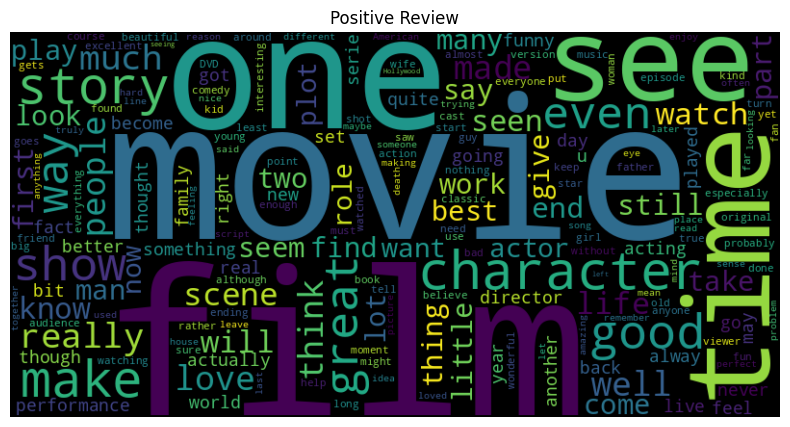

In [18]:
positive = train_df[train_df['sentiment']==1]['Cleaned_sentence'].tolist()
generate_wordcloud(positive,'Positive Review')

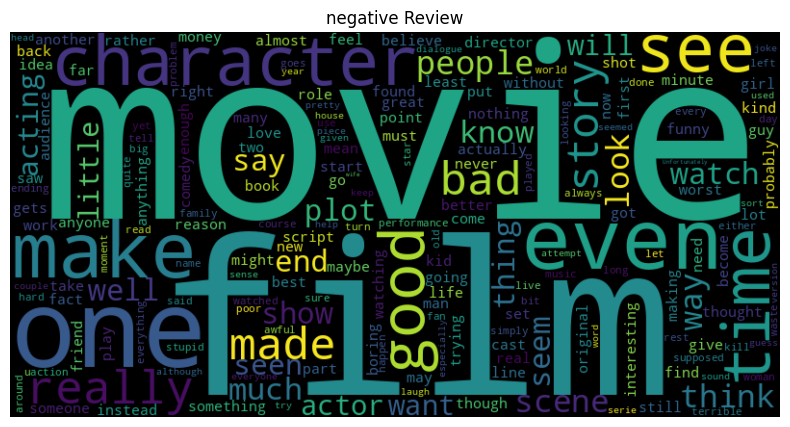

In [19]:
negative = train_df[train_df['sentiment']==0]['Cleaned_sentence'].tolist()
generate_wordcloud(negative,'negative Review')

In [20]:
# Training data
#Reviews = "[CLS] " +train_df['Cleaned_sentence'] + "[SEP]"
Reviews = train_df['Cleaned_sentence']
Target = train_df['sentiment']
 
# Test data
#test_reviews =  "[CLS] " +test_df['Cleaned_sentence'] + "[SEP]"
test_reviews = test_df['Cleaned_sentence']
test_targets = test_df['sentiment']

In [21]:
x_val, x_test, y_val, y_test = train_test_split(test_reviews,
                                                    test_targets,
                                                    test_size=0.5, 
                                                    stratify = test_targets)

## Tokenization & Encoding

In [22]:
#Tokenize and encode the data using the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



In [ ]:
max_len= 128
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(Reviews.tolist(),
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')
 
X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(), 
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')
 
X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(), 
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

In [29]:
k = 0
print('Training Comments -->>',Reviews[k])
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][k])
print('\nLabels -->>',Target[k])

Training Comments -->> I don't think I need to tell you the story For it has been told for years and years So I will just share my feelings I first saw Cinderella was when I was five years old From then on I was a Disney child in a good way The animation now seems childish and old fashioned, but that is part of its charm now Now, in the age of High School Musical and computer generated images, it seems like people have forgotten the genius and magical essence of early Disney movies Thankfully I was born before that so I was introduced to this classic And it seems no matter how old I get, I turn back into that five year old watching it on VHS Which is the true magic of Disney

Input Ids -->>
 tf.Tensor(
[  101  1045  2123  1005  1056  2228  1045  2342  2000  2425  2017  1996
  2466  2005  2009  2038  2042  2409  2005  2086  1998  2086  2061  1045
  2097  2074  3745  2026  5346  1045  2034  2387 21686  2001  2043  1045
  2001  2274  2086  2214  2013  2059  2006  1045  2001  1037  6373  2

## Build the classification model

In [30]:
# Intialize the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
# Compile the model with an appropriate optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [32]:
# Step 5: Train the model
history = model.fit(
    [X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
    Target,
    validation_data=(
      [X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
    batch_size=16,
    epochs=3
)

Epoch 1/3
1563/1563 [==============================] - 953s 589ms/step - loss: 0.2874 - accuracy: 0.8753 - val_loss: 0.2128 - val_accuracy: 0.9166
Epoch 2/3
1563/1563 [==============================] - 917s 587ms/step - loss: 0.1640 - accuracy: 0.9396 - val_loss: 0.2353 - val_accuracy: 0.9036
Epoch 3/3
1563/1563 [==============================] - 917s 587ms/step - loss: 0.0954 - accuracy: 0.9680 - val_loss: 0.2543 - val_accuracy: 0.9170


In [33]:
#Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
    y_test
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

391/391 [==============================] - 127s 324ms/step - loss: 0.2574 - accuracy: 0.9181
Test loss: 0.2574085295200348, Test accuracy: 0.9180799722671509


In [34]:
path = '/kaggle/working/'
# Save tokenizer
tokenizer.save_pretrained(path +'/Tokenizer')
 
# Save model
model.save_pretrained(path +'/Model')

In [35]:
# Load tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(path +'/Tokenizer')
 
# Load model
bert_model = TFBertForSequenceClassification.from_pretrained(path +'/Model')

Some layers from the model checkpoint at /kaggle/working//Model were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /kaggle/working//Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


## predict the sentiment of the test dataset

In [36]:
pred = bert_model.predict(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])
 
# pred is of type TFSequenceClassifierOutput
logits = pred.logits
 
# Use argmax along the appropriate axis to get the predicted labels
pred_labels = tf.argmax(logits, axis=1)
 
# Convert the predicted labels to a NumPy array
pred_labels = pred_labels.numpy()
 
label = {
    1: 'positive',
    0: 'Negative'
}
 
# Map the predicted labels to their corresponding strings using the label dictionary
pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_test]
 
print('Predicted Label :', pred_labels[:10])
print('Actual Label    :', Actual[:10])

391/391 [==============================] - 127s 318ms/step
Predicted Label : ['Negative', 'Negative', 'Negative', 'positive', 'positive', 'Negative', 'positive', 'Negative', 'positive', 'Negative']
Actual Label    : ['positive', 'Negative', 'Negative', 'positive', 'positive', 'Negative', 'positive', 'Negative', 'positive', 'Negative']


In [37]:
print("Classification Report: \n", classification_report(Actual, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.93      0.90      0.92      6250
    positive       0.90      0.94      0.92      6250

    accuracy                           0.92     12500
   macro avg       0.92      0.92      0.92     12500
weighted avg       0.92      0.92      0.92     12500



## Prediction with user inputs

In [38]:
def Get_sentiment(Review, Tokenizer=bert_tokenizer, Model=bert_model):
    # Convert Review to a list if it's not already a list
    if not isinstance(Review, list):
        Review = [Review]
 
    Input_ids, Token_type_ids, Attention_mask = Tokenizer.batch_encode_plus(Review,
                                                                             padding=True,
                                                                             truncation=True,
                                                                             max_length=128,
                                                                             return_tensors='tf').values()
    prediction = Model.predict([Input_ids, Token_type_ids, Attention_mask])
 
    # Use argmax along the appropriate axis to get the predicted labels
    pred_labels = tf.argmax(prediction.logits, axis=1)
 
    # Convert the TensorFlow tensor to a NumPy array and then to a list to get the predicted sentiment labels
    pred_labels = [label[i] for i in pred_labels.numpy().tolist()]
    return pred_labels

In [39]:
Review ='''Bahubali is a blockbuster Indian movie that was released in 2015. 
It is the first part of a two-part epic saga that tells the story of a legendary hero who fights for his kingdom and his love. 
The movie has received rave reviews from critics and audiences alike for its stunning visuals, 
spectacular action scenes, and captivating storyline.'''
Get_sentiment(Review)

1/1 [==============================] - 3s 3s/step


['positive']